### <center> 1. Знакомимся с данными

Интересующие нас данные хранятся в таблицах `city`, `customer`, `driver`, `shipment`, `truck`. Давайте внимательно их изучим.

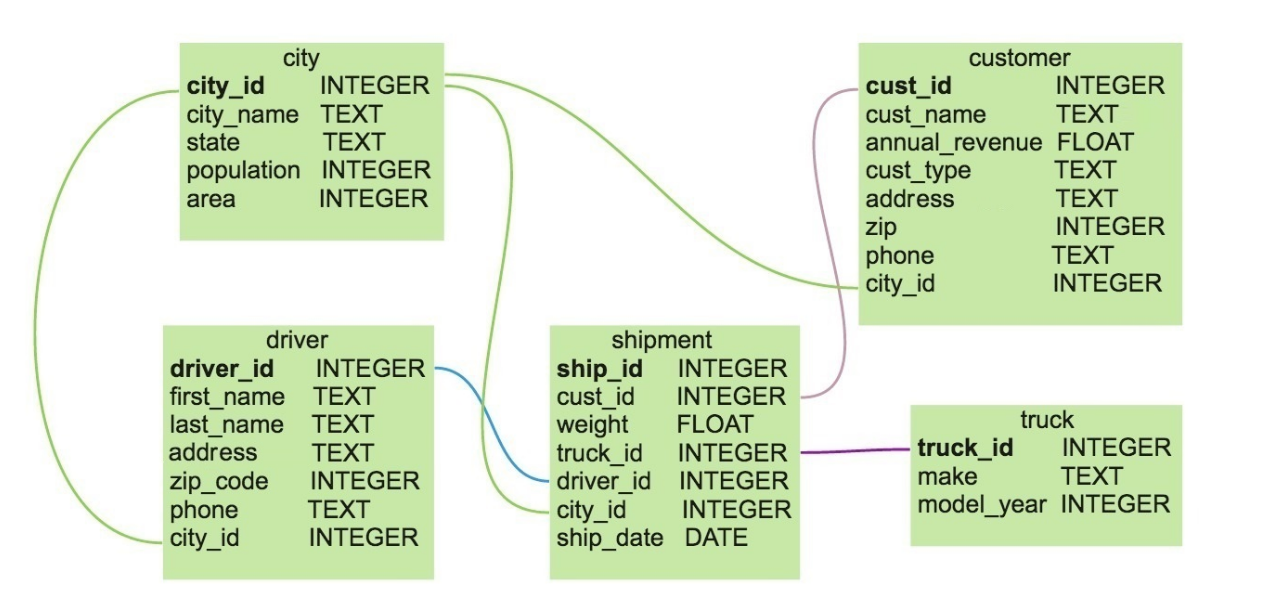

Тaблица `city`:

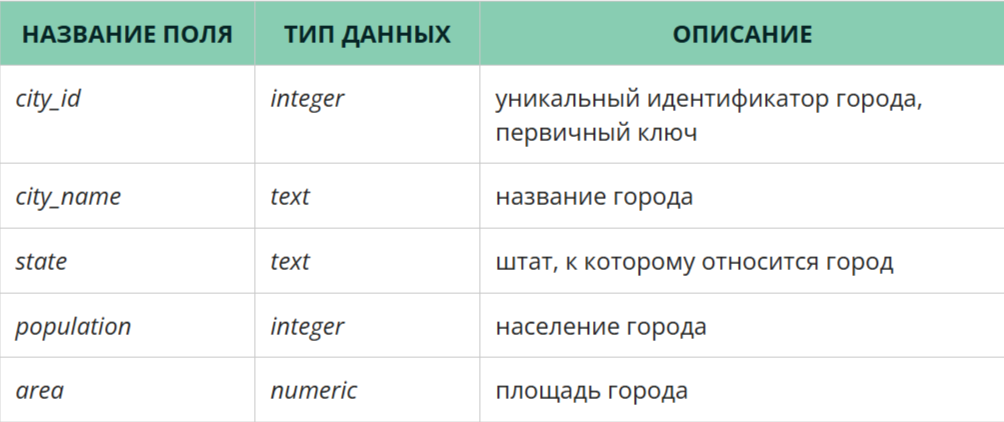

Таблица `customer` — это справочник клиентов:

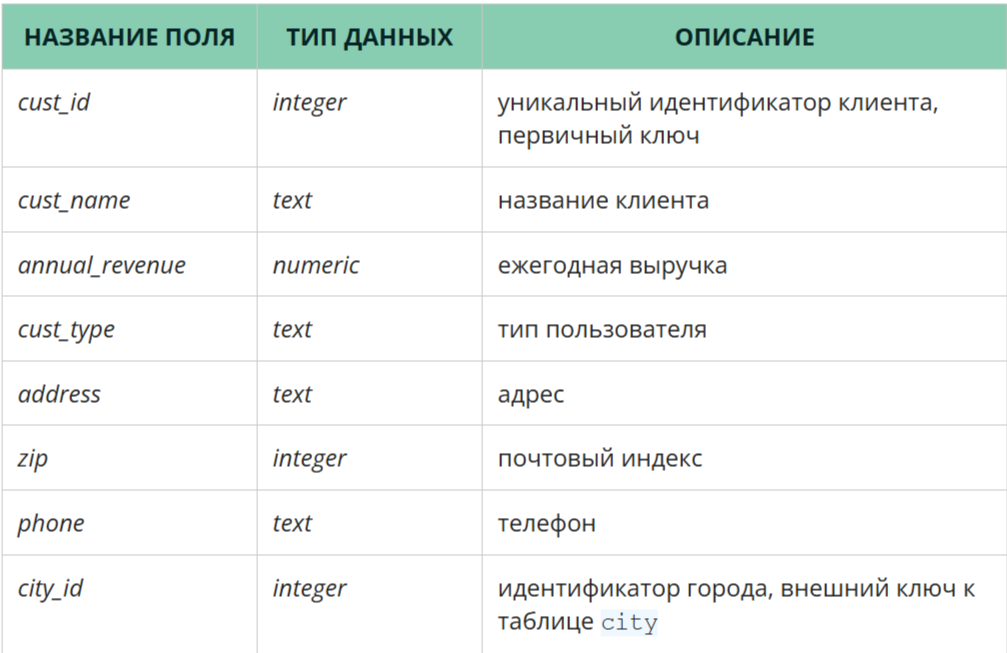

Таблица `driver` — справочник водителей:

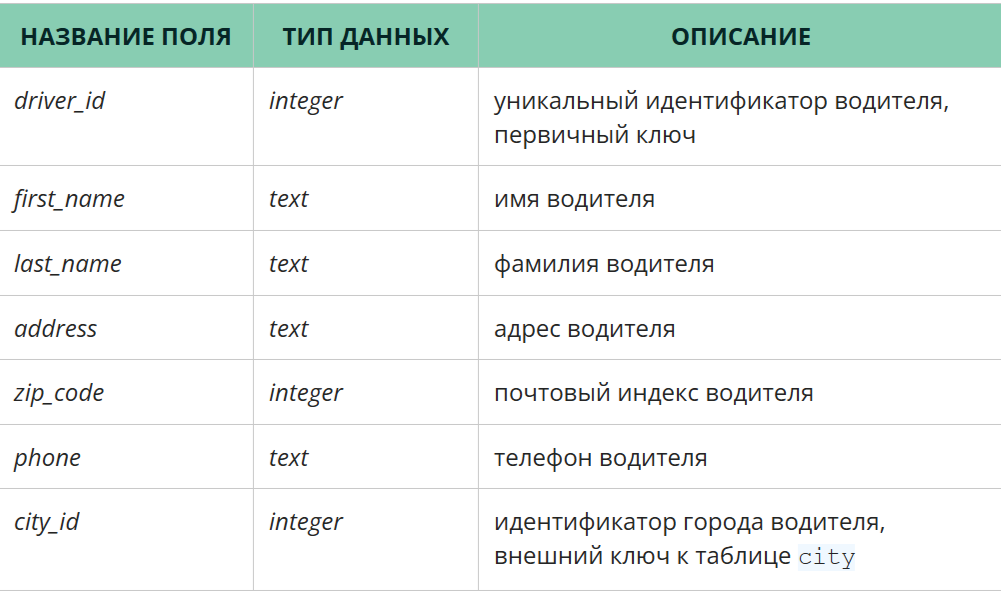

В таблице `truck` хранится информация о грузовиках

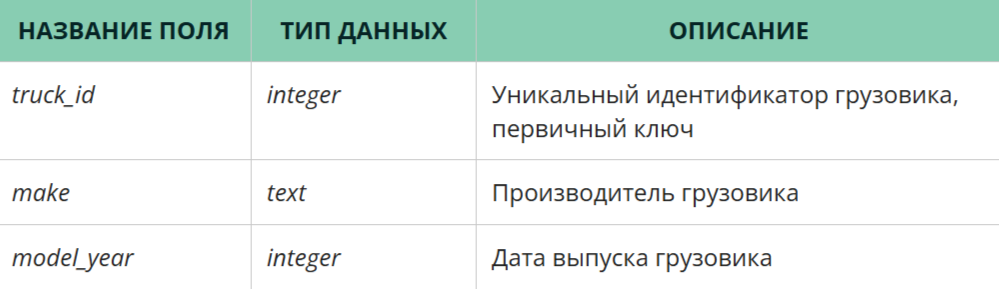

`shipment` — таблица с данными о доставках:

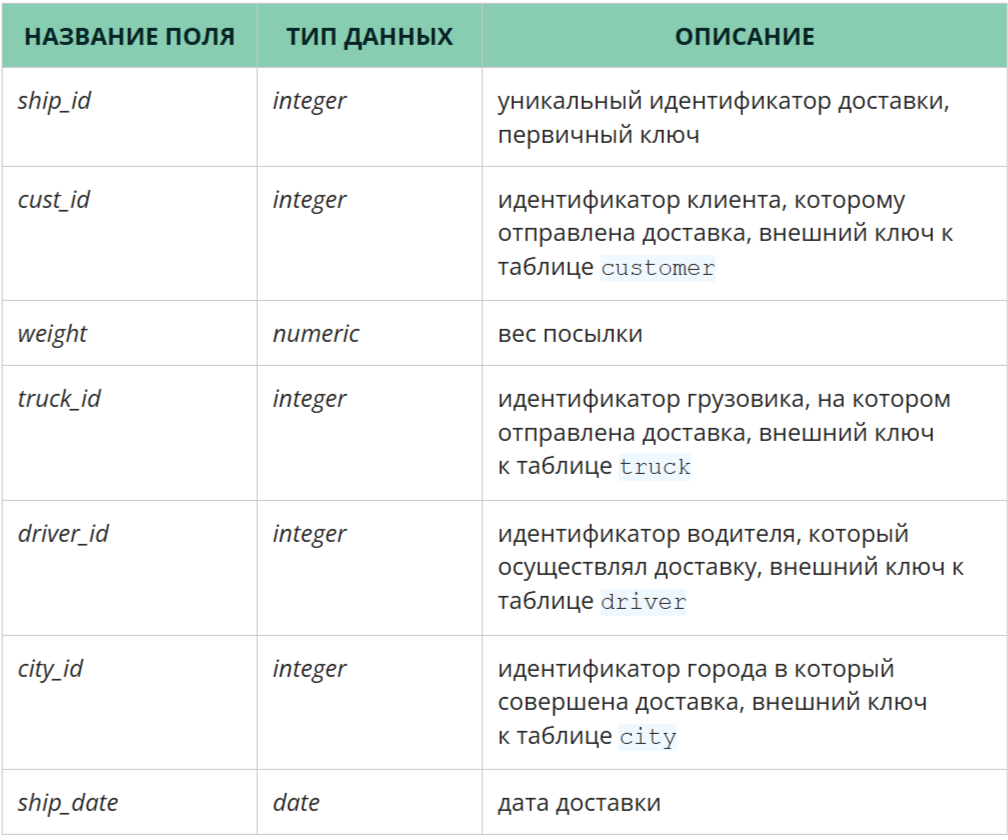

**Задание 1.1**

→ Укажите название города с максимальным весом единичной доставки.

```sql
SELECT
    city.city_name,
    s.weight
FROM
    sql.city as city
    JOIN sql.shipment as s ON city.city_id = s.city_id
GROUP BY city.city_name, s.weight
order by s.weight desc 
LIMIT 1
```

→ Сколько различных производителей грузовиков перечислено в таблице `truck`?

```sql
SELECT
    COUNT(DISTINCT make) AS unique_maker
FROM sql.truck
```

→ Как зовут водителя (`first_name`), который совершил наибольшее количество доставок одному клиенту?

```sql
SELECT
    d.first_name,
    c.cust_id,
    COUNT(s.ship_id) as total_shipment
FROM sql.driver as d
    JOIN sql.shipment as s ON d.driver_id = s.driver_id
    JOIN sql.customer as c ON s.cust_id = c.cust_id
GROUP BY 
    d.driver_id,
    d.first_name,
    c.cust_id
ORDER BY
    total_shipment DESC
LIMIT 1
```

→ Укажите даты первой и последней по времени доставок в таблице `shipment`

```sql
SELECT
    ship_date
FROM sql.shipment
ORDER BY ship_date ASC
```

→ Укажите имя клиента, получившего наибольшее количество доставок за 2017 год.
```sql
SELECT
    c.cust_name,
    COUNT(DISTINCT s.ship_id) AS total_ship
FROM sql.customer as c
    JOIN sql.shipment as s ON c.cust_id = s.cust_id
WHERE s.ship_date BETWEEN '2016-12-31' AND '2017-12-31'
GROUP BY
    c.cust_id,
    c.cust_name
ORDER BY total_ship DESC
LIMIT 1
```

### <center> 2. UNION

##### <center> ПРИНЦИП И УСЛОВИЯ РАБОТЫ UNION

Допустим, мы хотим собрать из справочников по книгам и фильмам один, так чтобы в нём содержались названия произведений, а также их описание — книга или фильм.

Для этого напишем простой запрос:

```sql
SELECT          book_name object_name, 'книга' object_description /*выбираем столбец с названием book_name, задаём алиас для столбца object_name, задаём во второй колонке объект ‘книга’ с алиасом для столбца object_descritption*/
FROM          public.books
UNION ALL /*оператор присоединения*/
SELECT          movie_title, 'фильм' /*выбираем столбец movie_title, сами задаём во второй колонке объект ‘фильм’*/
FROM          sql.kinopoisk /*из схемы sql и таблицы kinopoisk*/

Визуально произведённое нами действие можно представить следующим образом:

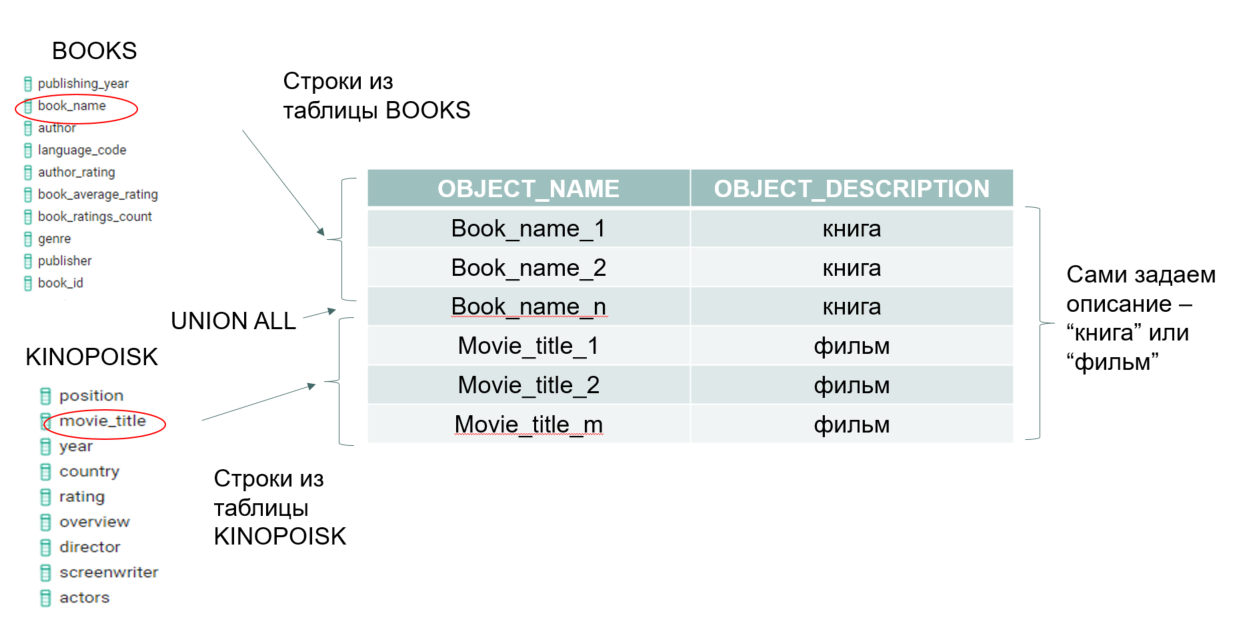

`UNION` - Оператор присоединения, выводит только уникальные записи

>**Важно!** `UNION` оставляет только уникальные значения, а потому требует дополнительных вычислительных мощностей и памяти (в данном случае можно провести аналогию с `DISTINCT`). Поэтому если вы уверены в отсутствии дубликатов в данных или они вам не важны, предпочтительнее использовать `UNION ALL`.

`UNION ALL` — Присоединяет любой результат запроса к другому «снизу» при условии, что у них одинаковая структура, а именно:

- одинаковый тип данных;
- одинаковое количество столбцов;
- одинаковый порядок столбцов согласно типу данных.

`UNION ALL` присоединяет все строки последующих таблиц к предыдущим, без ограничений по уникальности.

**СИНТАКСИС**
```sql
SELECT         n columns
FROM 
         table_1
UNION ALL
SELECT 
         n columns
FROM 
         table_2
...
UNION ALL
SELECT 
         n columns
FROM 
         table_n
```

Результатом выполнения такого запроса будут строки `table_1`, `table_2`, ..., `table_n`, соединённые одни под другими и выведенные в единой выдаче.

>**Важно!** Названия итоговых колонок в выводе будут такие же, как в первом блоке `SELECT`, даже если они отличаются в других блоках подзапросов.

---

Обратимся к нашему датасету о транспортной компании и посмотрим, как сформировать справочник с *ID* всех таблиц и указанием объекта, к которому он относится.

```sql
SELECT
    c.city_id as object_name, 'id города' object_type
FROM
    sql.city as c
UNION ALL
SELECT
    d.driver_id as other_name, 'id водителя' as other_type
FROM
    sql.driver as d
UNION ALL
SELECT
    s.ship_id, 'id доставки'
FROM
    sql.shipment as s
UNION ALL
SELECT
    c.cust_id, 'id клиента'
FROM
    sql.customer as c
UNION ALL
SELECT
    t.truck_id, 'id грузовика'
FROM
    sql.truck t
ORDER BY 1
```

>**Обратите внимание!** Несмотря на исходные названия колонок `other_name` и `other_type` во втором подзапросе, в выводе мы получим названия, которые дали в первом блоке: `object_name` и `object_type`.

>Другая особенность — в применении сортировки `ORDER BY`: она всегда будет относиться к итоговому результату всего запроса с `UNION ALL`.

В случаях, когда необходимо применить команду `ORDER BY` или `LIMIT` не к итоговому результату, а к каждой части запроса, можно обернуть подзапросы в скобки.

```sql
SELECT
    book_name as object_name, 'книга' as object_description
FROM
    public.books
UNION ALL
SELECT
    movie_title, 'фильм'
FROM
    sql.kinopoisk
ORDER BY 1
LIMIT 1
```

В таком случае будет отсортирован будет **весь общий справочник**, а в выводе останется одна строка с названием объекта, идущим первым по алфавиту.

В случае, если нам нужны строки с названием как фильма, так и книги, идущих первыми по алфавиту, необходимо отсортировать каждую часть запроса по отдельности и объединить результаты

Добавим `ORDER BY` и `LIMIT` ещё и в превую часть запроса, и добавим скобки, чтобы не было синтаксической ошибки, связанной с неправильным положением операторов:

```sql
(SELECT
    book_name as object_name, 'книга' object_description
FROM
    public.books
ORDER BY
    1
LIMIT 1)
UNION ALL
(SELECT
    movie_title, 'фильм'
FROM
    sql.kinopoisk
ORDER BY 1
LIMIT 1)
```

**Задание 2.1**

Напишите запрос, который создает уникальный алфавитный справочник всех городов, штатов, имён водителей и производителей грузовиков. Результатом запроса должны быть два столбца: название и тип объекта (city, state, driver, truck). Отсортируйте список по названию объекта, а затем — по типу.

```sql
SELECT
    c.city_name as "название", 'city' as "тип объекта"
FROM
    sql.city as c
UNION
SELECT
    c.state, 'state'
FROM
    sql.city as c
UNION
SELECT
    d.first_name, 'driver'
FROM
    sql.driver as d
UNION
SELECT
    t.make, 'truck'
FROM
    sql.truck as t
ORDER BY 1, 2
```

**Задание 2.2**

Напишите запрос, который соберёт имена всех упомянутых городов и штатов из таблицы `city`. Результатом запроса должен быть один столбец `object_name`, отсортированный в алфавитном порядке.

```sql
SELECT
    city_name as object_name
FROM
    sql.city
UNION ALL
SELECT
    state as object_name
FROM
    sql.city
ORDER BY object_name
```


**Задание 2.3**

Выполнив предыдущий запрос, мы получили города с одинаковыми названиями, но находящиеся в разных штатах, а также большое количество дублирующихся названий штатов. Перепишите предыдущий запрос так, чтобы остались только уникальные названия городов и штатов. Результатом запроса должен быть один столбец object_name, отсортированный в алфавитном порядке.

```SQL
SELECT
    city_name as object_name
FROM
    sql.city
UNION ALL
SELECT
    state as object_name
FROM
    sql.city
ORDER BY object_name
```

### <center>  3. UNION и ограничение типов данных

##### <center> ПОЧЕМУ ТАК ВАЖЕН ТИП ДАННЫХ?

Выведем список всех id городов и их названий в одном столбце.

```sql
SELECT
    c.city_id
FROM
    sql.city as c
UNION ALL
SELECT
    cc.city_name
FROM
    sql.city as cc
```

Вместо результата вы получите сообщение об ошибке: `"ERROR: UNION types integer and text cannot be matched"`. Дело в том, что мы попытались объединить **числовой** и **строковый** типы в одной колонке, а это невозможно.

>Если мы всё же хотим выполнить поставленную задачу, придётся привести оба столбца к одному типу данных. Не каждый текст может быть приведён к числу, зато каждое число может быть представлено в текстовом формате.

Для типизации в *Postgres* составляется запрос по модели `column_name::column_type`.

Таким образом, чтобы перевести `city_id` в текст, нам потребуется написать `city_id::text`.

>**Важно!** Любой тип данных может быть приведён к текстовому формату — эту возможность целесообразно использовать для соединения разнородных сущностей. Главное — помнить, что **сортировка текста отличается** от сортировки чисел и дат.

```sql
SELECT
    c.city_id::text /*выбираем столбец city_id, переводим city_id из числового в текстовый формат*/
FROM
    sql.city as c
UNION ALL
SELECT
    cc.city_name
FROM
    sql.city as cc


**Задание 3.1**

Напишите запрос, который объединит в себе все почтовые индексы водителей и их телефоны в единый столбец-справочник contact. Также добавьте столбец с именем водителя first_name и столбец contact_type с типом контакта (phone или zip в зависимости от типа). Отсортируйте список по столбцу с контактными данными в порядке возрастания, а затем — по имени водителя.

```sql
SELECT
    zip_code::text as contact,
    first_name,
    'zip' as contact_type
FROM sql.driver
UNION ALL
SELECT
    phone,
    first_name,
    'phone' AS contact_type
FROM 
    sql.driver
ORDER BY 1, 2
```

### <center> 4. UNION ALL и промежуточные итоги

##### <center> ВОЗМОЖНОСТИ UNION

✍ Помимо соединения разнородных сущностей в единый справочник, `UNION ALL` часто используется для **подведения промежуточных итогов** и **выведения результатов агрегатных функций**.

Кроме агрегатных функций, в запросах с `UNION` могут использоваться функции группировки и выборки.


Выведем обобщённые данные о населении по всем городам, с детализацией до конкретного города

```sql
SELECT
    c.city_name,
    c.population
FROM
    sql.city as c
UNION ALL
SELECT
    'total',
    SUM(c.population)
FROM
    sql.city c
ORDER BY 2 DESC
```
Визуально это действие можно представить так:

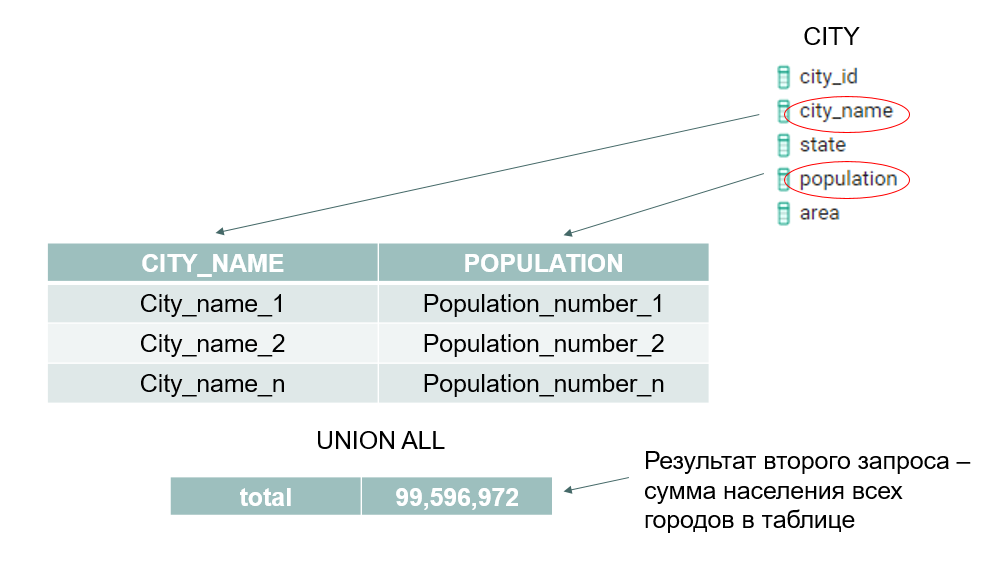

Выполнив запрос в Metabase, вы заметите, что сначала выведен итоговый результат с суммой населения всех городов в таблице, а затем по каждому городу в отдельности.

**Задание 4.1**

Напишите запрос, который выводит общее число доставок total_shipments, а также количество доставок в каждый день. Необходимые столбцы: date_period, cnt_shipment. Не забывайте о единой типизации. Упорядочите по убыванию столбца date_period.

```sql
SELECT
    ship_date::text as date_period,
    COUNT(*) AS cnt_shipment
FROM
    sql.shipment
GROUP BY ship_date::text
UNION ALL
SELECT
    'total_shipments' as total_shipments,
    COUNT(*)
FROM
    sql.shipment
ORDER BY date_period DESC
```

### <center>  5. UNION и дополнительные условия

✍ UNION также может быть использован для разделения существующей выборки по критерию «выполнение определённого условия».

Например, с помощью `UNION` можно отобразить, у кого из водителей заполнен столбец с номером телефона.

```sql
SELECT
    d.first_name,
    d.last_name,
    'телефон заполнен' phone_info
FROM
    sql.driver d
WHERE d.phone IS NOT NULL
UNION
SELECT
    d.first_name,
    d.last_name,
    'телефон не заполнен' phone_info
FROM
    sql.driver d
WHERE d.phone IS NULL
```

**Задание 5.1**

Напишите запрос, который выведет все города (city_name) и штаты (state), в которых они расположены (таблица city), а также информацию о том, была ли осуществлена доставка в этот город (таблица shipment):

- если в город была осуществлена доставка, то выводим 'доставка осуществлялась';
- если нет — выводим 'доставка не осуществлялась'.

Столбцы к выводу: city_name, state, shipping_status. Отсортируйте в алфавитном порядке по городу, а затем — по штату.

```sql
SELECT 
     c.city_name AS city_name,
     c.state AS state,
    'доставка осуществлялась' AS shipping_status
FROM 
    sql.city c
    LEFT JOIN sql.shipment s ON c.city_id=s.city_id
WHERE s.city_id IS NOT NULL
UNION
SELECT 
     c.city_name AS city_name,
     c.state AS state,
    'доставка не осуществлялась' AS shipping_status
FROM 
    sql.city c
    LEFT JOIN sql.shipment s ON c.city_id=s.city_id
WHERE s.city_id IS NULL
ORDER BY 1, 2


**Задание 5.2**

Напишите запрос, который выводит два столбца: city_name (таблица city) и shippings_fake. Выведите города (таблица city), куда совершались доставки. Пусть первый столбец содержит название города, а второй формируется так:

- если в городе было более десяти доставок (ship_id, таблица shipment), вывести количество доставок в этот город как есть;
- иначе — вывести количество доставок, увеличенное на пять.

Отсортируйте по убыванию получившегося «нечестного» количества доставок, а затем — по имени в алфавитном порядке.

```sql
SELECT
    c.city_name AS city_name,
    COUNT(s.ship_id) as shippings_fake
FROM
    sql.city as c
    JOIN sql.shipment as s ON c.city_id = s.city_id
GROUP BY c.city_name
HAVING COUNT(s.ship_id) > 10
UNION ALL
SELECT
    c.city_name,
    COUNT(s.ship_id) + 5 AS shippings_fake
FROM
    sql.city as c
    JOIN sql.shipment as s ON c.city_id = s.city_id
GROUP BY c.city_name
HAVING COUNT(s.ship_id) <= 10

ORDER BY shippings_fake DESC, city_name asc
```

### <center> 6. UNION и ручная генерация

✍ `UNION` можно использовать для создания справочников прямо в коде запроса. К примеру, если мы хотим вручную ввести какие-то значения и произвести с ними некоторые манипуляции или дополнить существующую выдачу своими значениями.

Составим запрос, который позволит вывести первые три буквы алфавита и их порядковые номера.

```sql
SELECT
    'a', letter, '1' ordinal_position
UNION
SELECT
    'b', '2'
UNION
SELECT
    'c', '3'
```

>Существуют сложные алгоритмы сравнения текстовых значений, но главный смысл сводится к одному: сравнение производится на основе таблицы *unicode* и позиции элемента в ней с учётом определённых условий.

**Задание 6.1**

Напишите запрос, который выберет наибольшее из числовых значений:

1000000;
541;
-500;
100.
Столбец с результатом назовите result.

```sql
SELECT
    MAX(value) as result
FROM
    (
        SELECT 1000000 AS value
        UNION ALL
        SELECT 541 AS value
        UNION ALL
        SELECT -500 AS value
        UNION ALL
        SELECT 100 AS value
    ) AS values_list


**Задание 6.2**

Помним, что сортировка для числовых и строковых типов данных отличается. Построив запрос по аналогии с примером, приведите значения к текстовому типу данных, сравните и выберите наибольшее из них:

1000000;
541;
-500;
100.
Столбец с ответом назовите mycol

```sql
SELECT
    MAX(value::text) as mycol
FROM
    (SELECT 1000000 AS value
    UNION ALL
    SELECT 541 as value
    UNION ALL
    SELECT -500 AS value
    UNION ALL
    SELECT 100 AS value) as value_list

**Задание 6.3**

Построив запрос по аналогии с примером, найдите самое большое значение из перечисленных операторов:

- + ;
- - ;
- = ;
- / .
Столбец с ответом назовите result

```sql
SELECT
    MAX(value) as result
FROM
    (SELECT '+' AS value
    UNION ALL
    SELECT '-' as value
    UNION ALL
    SELECT '=' AS value
    UNION ALL
    SELECT '/' AS value) as value_list
```